In [1]:
#%load_ext line_profiler

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation, sim_synaptic_kernel
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_spikes_synaptic, exp_decay_func, sim_acf_cos
from timescales.est import compute_acf, fit_acf, fit_acf_cos, fit_psd, convert_knee_val

### Inverting Simulations
This notebook tries to determine a method for taking a single simulated neuron and infer the probability distribution that generated it - the inverse of the simulation process.

It turns out that for each convolution with a Poisson spike and decay kernel, sampling the resulting segment of the probability distribution will generate a number of spikes equal to tau * fs, on average:

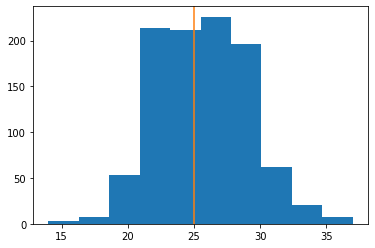

In [2]:
tau = 0.025 
fs = 1000
exp = sim_synaptic_kernel(10 * tau, fs, 0, tau)

probs = np.zeros(200)
probs[0] = 1
probs = np.convolve(probs, exp)
probs = probs / probs.max()

n_iters = 1000
spikes = np.zeros((n_iters, len(probs)))
for n in range(n_iters):
    for i, p in enumerate(probs):
        spikes[n, i] = np.random.rand() > (1-p)
        
plt.hist(spikes.sum(axis=1))
plt.axvline(tau * fs, color='C1');

This means if we slide a window through the a binary spiking array and sum of spikes in that window == tau * fs, the start of that window likely represents a 1 in the original Poisson array. Exact multiples of tau * fs, represent windows with where multiple spikes occur - in cases where spikes overlap do to small mus.

This provides a possible way to move from a binary spiking array to a continuous approximation of the probability distribution that generated it. It's a crude approximation but it allows improved tau estimation relative to using a single spiking array.

In [3]:
# Settings
tau = 0.025
n_seconds = 10
fs = 1000
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
mu = 50

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

# Randomly sample isi's
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=bool)
poisson[inds] = True

# Convolve the binary poisson array with the kernel
probs = np.convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

n_neurons = 1
spikes = np.zeros((n_neurons, len(probs)), dtype=bool)
for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
times = times[:n_samples]
spikes = spikes[0, :n_samples]
poisson = poisson[:n_samples]

Text(0.5, 0, 'Time (seconds)')

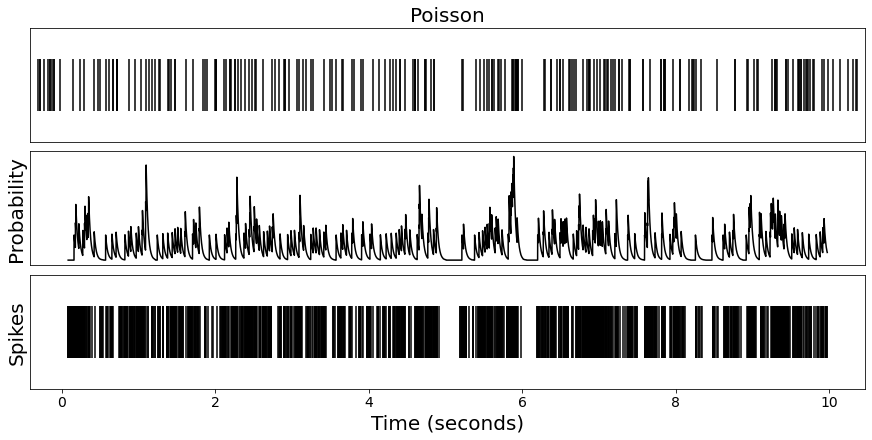

In [4]:
fig, axes = plt.subplots(constrained_layout=True, figsize=(12, 6), nrows=3)

axes[0].eventplot(times[poisson], color='k')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].set_title('Poisson', size=20)
axes[0].set_xlim(times[poisson][0]-.1, times[poisson][-1]+.1)


axes[1].plot(times, probs, color='k')
axes[1].set_ylabel('Probability', size=20)
axes[1].set_yticks([])
axes[1].get_xaxis().set_visible(False)

axes[2].eventplot(times[spikes], color='k')
axes[2].set_ylabel('Spikes', size=20)
axes[2].set_yticks([])
axes[2].tick_params(axis='x', labelsize=14)
axes[2].set_xlabel('Time (seconds)', size=20)

The process below counts the number of spikes per window to estimated and instantaneous tau on a sample by sample basis. The tau value is then used to simulate a decay, which is convolved on the current sample. A few different windows sizes are swept throught - the ideal window size is the time it takes the exponential decay to reach zero.

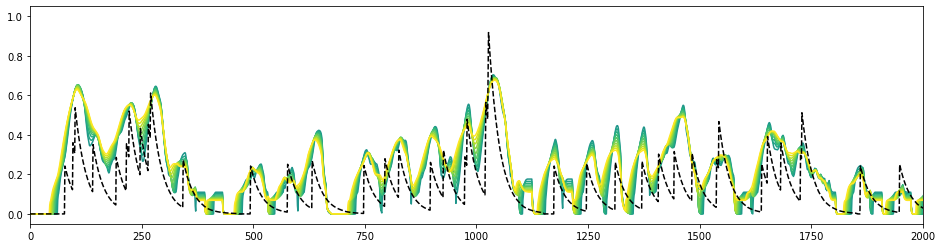

In [5]:
plt.figure(figsize=(16, 4))
           

steps = np.arange(20, 40, 2)

cmap = plt.get_cmap('viridis')
colors = cmap(steps/steps.max())

rolled_sums = np.zeros((len(steps), len(spikes)))

for ci, s in enumerate(steps):
    
    win_len = s

    n_shifts = len(spikes)-win_len

    rolled_sum = np.zeros(n_shifts)
    for i in range(n_shifts):
        
        sp_count = np.roll(spikes, -i)[:win_len].sum()

        if sp_count >= 1:

            exp = sim_synaptic_kernel(5 * sp_count/fs, fs, 0, sp_count/fs)
            exp = exp / exp.max()

            if i+len(exp) < len(rolled_sum):
                rolled_sum[i:i+len(exp)] += exp
            else:
                x = len(rolled_sum[i:])
                rolled_sum[i:] += exp[:x]
    
    rolled_sum = rolled_sum / rolled_sum.max()
    
    rolled_sums[ci, :len(rolled_sum)] = rolled_sum
    
    plt.plot(rolled_sum, color=colors[ci], label=f'{s}')

plt.plot(probs[:len(rolled_sum)], color='k', alpha=1, ls='--')
plt.xlim(0, 2000);

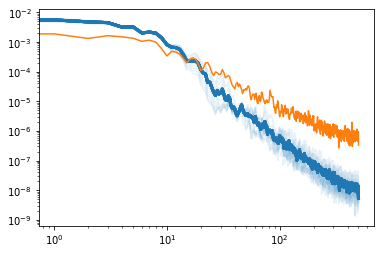

In [6]:
freqs_rolled, powers_rolled = compute_spectrum(rolled_sums, fs)
freqs_probs, powers_probs = compute_spectrum(probs , fs)

for p in powers_rolled:
    plt.loglog(freqs_rolled, p, alpha=.1, color='C0')

    plt.plot(powers_rolled.mean(axis=0), alpha=.8, lw=3, color='C0')
plt.loglog(freqs_probs, powers_probs, color='C1')

In [7]:
print('Ground Truth      :', tau)
print('Probabilitiy Array:', fit_psd(freqs_probs, powers_probs, (0, 20))[-1])
print('Rolling Spike Sum: ', fit_psd(freqs_rolled, powers_rolled, (0, 20), mode='mean')[-1])

Ground Truth      : 0.025
Probabilitiy Array: 0.02030268373052119
Rolling Spike Sum:  0.02857133914546052
